In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

import gc
from tqdm.notebook import tqdm

from astropy.coordinates import SkyCoord, matching
import astropy.io.ascii
import astropy.units as u

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()


def summary_stats(preds, trues, mask):
    """Given preds, trues, and some PR conditional mask, 
    output the total number (N), RMSE, slope, std, and offset.
    """    
    return (
        sum(mask), 
        ((preds[mask] - trues[mask])**2).mean()**0.5, 
        slope(preds[mask], trues[mask]),
        (preds[mask] - trues[mask]).std(), 
        (preds[mask].mean() - trues[mask].mean()),
    )



In [4]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]


# Get $\alpha$.40 data

In [5]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

df.head()

,AGCNr,logfgas
0,331061,-0.447361
1,101866,-1.089920
2,101869,-0.350810
3,331082,0.104468
4,101873,-0.153950


In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

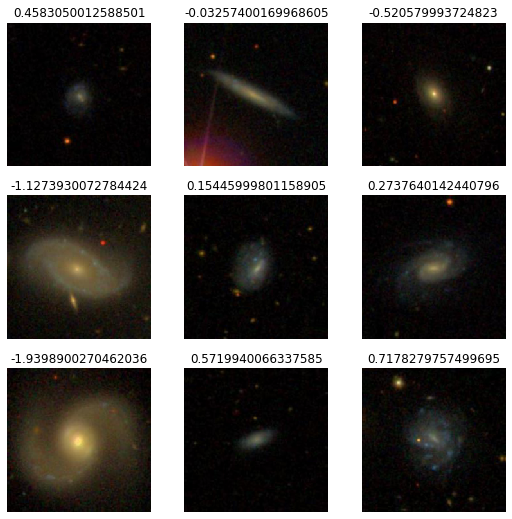

In [7]:
dls.show_batch()

# Train

In [7]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.009120108559727669)

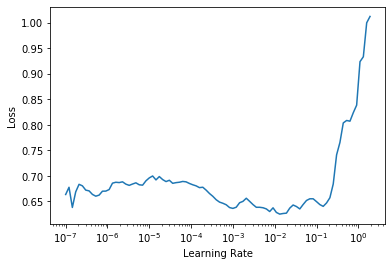

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.433506,0.369223,00:32
1,0.339782,0.342082,00:32
2,0.331865,0.444210,00:32
3,0.331396,0.316272,00:32
4,0.317954,0.339526,00:32
5,0.329791,0.302487,00:32
6,0.317036,0.355478,00:32
7,0.313325,0.488205,00:32
8,0.297874,0.303083,00:32
9,0.295228,0.286822,00:32


Wow, this does really well! ~0.22 dex on my first try, and we can probably do better (since validation loss < training loss)

In [53]:
# learn.save('fastai2-xresnet34-a40A-1')
learn = learn.load('fastai2-xresnet34-a40A-1');

# Train multiple models for ensembling

In [18]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

In [22]:
for i in range(10):
    model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
    learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
    learn.fit_one_cycle(20, 1e-2, div_final=1e5)
    
    preds, trues = learn.tta()
    results = pd.DataFrame(
        {'fgas_pred': to_np(preds).flatten(), 'fgas_true': to_np(trues).flatten()},
        index=dls.valid.items.AGCNr.values,
    )
    
    results.to_csv(f'{PATH}/results/predictions/ensembles/fastai2-xresnet34-a40A-{i}.csv')
    
    model, learn = None, None
    gc.collect()

epoch,train_loss,valid_loss,time
0,0.446185,0.468066,00:32
1,0.360463,0.446852,00:32
2,0.343431,0.354547,00:32
3,0.341989,0.482096,00:32
4,0.333354,0.485586,00:32
5,0.311156,0.372216,00:32
6,0.317883,0.396677,00:32
7,0.300670,0.591043,00:32
8,0.290578,0.256705,00:32
9,0.280405,0.291367,00:32


epoch,train_loss,valid_loss,time
0,0.423751,0.378310,00:32
1,0.361580,0.484402,00:32
2,0.351340,0.376176,00:32
3,0.363609,0.346855,00:32
4,0.331519,0.647405,00:32
5,0.311850,0.491777,00:32
6,0.301479,0.619820,00:32
7,0.302780,0.249767,00:32
8,0.296186,0.245930,00:32
9,0.291208,0.321067,00:32


epoch,train_loss,valid_loss,time
0,0.437053,0.373878,00:32
1,0.380885,0.445314,00:32
2,0.371741,0.317628,00:32
3,0.342468,0.568154,00:32
4,0.346408,0.985912,00:32
5,0.317131,0.301215,00:32
6,0.303923,0.298129,00:32
7,0.293185,0.295619,00:32
8,0.288144,0.251726,00:32
9,0.287632,0.265607,00:32


epoch,train_loss,valid_loss,time
0,0.430581,0.407654,00:32
1,0.366639,0.545437,00:32
2,0.350297,0.492170,00:32
3,0.345052,0.384562,00:32
4,0.330593,0.274092,00:32
5,0.309085,0.288437,00:32
6,0.299178,0.293536,00:32
7,0.292304,0.281692,00:32
8,0.283925,0.264918,00:32
9,0.283201,0.252017,00:32


epoch,train_loss,valid_loss,time
0,0.441718,0.435114,00:32
1,0.365383,0.354490,00:32
2,0.353140,0.320135,00:32
3,0.344879,0.435106,00:32
4,0.325615,0.380794,00:32
5,0.315813,0.270232,00:32
6,0.303279,0.281296,00:32
7,0.294498,0.277978,00:32
8,0.294891,0.253959,00:32
9,0.286714,0.241854,00:32


epoch,train_loss,valid_loss,time
0,0.446426,0.414275,00:32
1,0.375525,0.782200,00:32
2,0.333599,0.382019,00:32
3,0.358164,0.541489,00:32
4,0.330761,0.719038,00:32
5,0.324744,0.294422,00:32
6,0.311098,0.354832,00:32
7,0.292844,0.330567,00:32
8,0.289804,0.335766,00:32
9,0.288179,0.292390,00:32


epoch,train_loss,valid_loss,time
0,0.427136,0.338961,00:32
1,0.360622,0.348763,00:32
2,0.364652,0.308402,00:32
3,0.328745,0.458025,00:32
4,0.344064,0.657890,00:32
5,0.313247,0.267664,00:32
6,0.296909,0.286978,00:32
7,0.295225,0.361821,00:32
8,0.291400,0.257135,00:32
9,0.284638,0.292820,00:32


epoch,train_loss,valid_loss,time
0,0.429827,0.385936,00:32
1,0.362328,0.443698,00:32
2,0.356734,0.290875,00:32
3,0.330898,0.347467,00:32
4,0.321567,0.419680,00:32
5,0.318276,0.266829,00:32
6,0.299970,0.257821,00:32
7,0.293200,0.437351,00:32
8,0.293383,0.306915,00:32
9,0.284572,0.290147,00:32


epoch,train_loss,valid_loss,time
0,0.455793,0.451034,00:32
1,0.374917,0.734245,00:32
2,0.355727,0.331023,00:32
3,0.357073,0.572203,00:32
4,0.336314,0.301166,00:32
5,0.362669,0.632594,00:32
6,0.325574,0.357840,00:32
7,0.308343,0.312040,00:32
8,0.294462,0.296228,00:32
9,0.296576,0.347828,00:32


epoch,train_loss,valid_loss,time
0,0.422078,0.460067,00:32
1,0.361416,0.454930,00:32
2,0.366197,0.359955,00:32
3,0.343602,0.360606,00:32
4,0.336095,0.318611,00:32
5,0.309250,0.290659,00:32
6,0.300796,0.389548,00:32
7,0.299247,0.360726,00:32
8,0.291010,0.274468,00:32
9,0.284070,0.298875,00:32


Get results

In [27]:
predictions = np.zeros((len(dls.valid_ds), 10))
for i in range(10):
    predictions[:,i] = pd.read_csv(f'{PATH}/results/predictions/ensembles/fastai2-xresnet34-a40A-{i}.csv').fgas_pred.values
    
trues = pd.read_csv(f'{PATH}/results/predictions/ensembles/fastai2-xresnet34-a40A-0.csv').fgas_true.values

In [34]:
preds = np.mean(predictions, axis=1)


Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

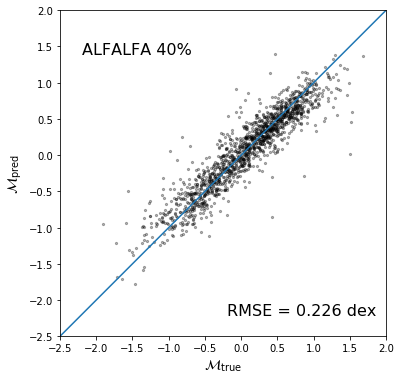

In [33]:
plt.figure(figsize=(6, 6))

plt.scatter(trues, preds, c='k', s=5, alpha=0.3)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

# plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: $\alpha.40$A (20%)', fontsize=14)
# plt.text(0.1, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(preds, trues):.2f}', fontsize=14)

plt.text(-2.2, 1.4, 'ALFALFA 40%', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

# plt.savefig(f'{PATH}/results/figures-updated/train_test-a40A.pdf')

# train deeper model for longer

In [61]:
model = xresnet50(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=0.013182567432522774)

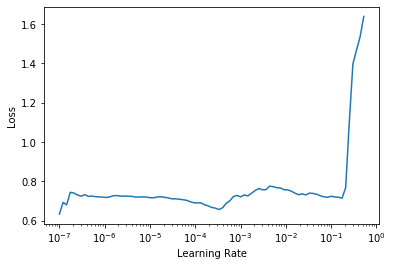

In [59]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(100, 1e-2)

epoch,train_loss,valid_loss,time
0,0.445103,0.456561,00:48
1,0.389483,0.467886,00:48
2,0.394967,0.358343,00:48
3,0.358824,0.371051,00:48
4,0.333300,0.460636,00:48
5,0.327316,0.289508,00:48
6,0.331065,0.494708,00:48
7,0.315031,0.341449,00:48
8,0.315419,0.257065,00:48
9,0.303080,0.339441,00:48


In [63]:
# learn.save('fastai2-xresnet50-a40A-1')
learn = learn.load('fastai2-xresnet50-a40A-1')

# Get results

In [56]:
preds, trues = learn.get_preds()
preds, trues = to_np(preds).flatten(), to_np(trues).flatten()

In [64]:
preds, trues = learn.tta()
preds, trues = to_np(preds).flatten(), to_np(trues).flatten()

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

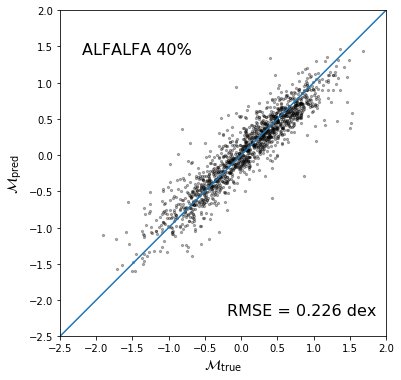

In [67]:
plt.figure(figsize=(6, 6))

plt.scatter(trues, preds, c='k', s=5, alpha=0.3)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

# plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: $\alpha.40$A (20%)', fontsize=14)
# plt.text(0.1, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(preds, trues):.2f}', fontsize=14)

plt.text(-2.2, 1.4, 'ALFALFA 40%', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

# plt.savefig(f'{PATH}/results/figures-updated/train_test-a40A.pdf')

# Get combined ALFALFA + xGASS predictions

In [8]:
df = pd.read_csv(f"{PATH}/data/combined.csv")

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),              
    get_x=ColReader(['id'], pref=f'{PATH}/images-combined/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

In [9]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

In [10]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.527292,0.450642,00:37
1,0.390179,0.386200,00:35
2,0.365274,0.404553,00:35
3,0.374033,0.443746,00:35
4,0.367815,0.770379,00:35
5,0.351151,0.360160,00:35
6,0.348982,0.512866,00:35
7,0.355790,0.377751,00:35
8,0.341578,0.607415,00:35
9,0.328805,0.321343,00:35


In [11]:
learn.save('fastai2-xresnet34-combined-1')
# learn = learn.load('fastai2-xresnet34-combined-1');

In [14]:
preds, trues = learn.tta()
preds, trues = to_np(preds).flatten(), to_np(trues).flatten()

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

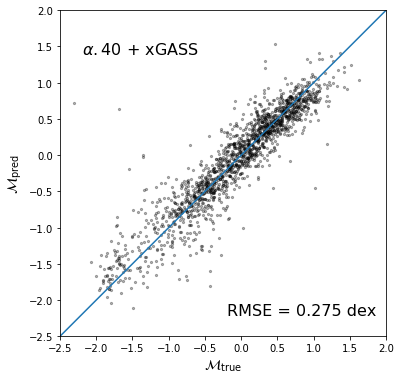

In [15]:
plt.figure(figsize=(6, 6))

plt.scatter(trues, preds, c='k', s=5, alpha=0.3)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

# plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: $\alpha.40$A (20%)', fontsize=14)
# plt.text(0.1, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(preds, trues):.2f}', fontsize=14)

plt.text(-2.2, 1.4, r'$\alpha.40$ + xGASS', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


# Try predicting on NIBLES
see nb `01`

In [12]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)]

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)
nibles.nibles_id = nibles.nibles_id.astype(str)

In [15]:
nibles_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['nibles_id'], pref=f'{PATH}/images-nibles_cleaned/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [16]:
nibles_dls = ImageDataLoaders.from_dblock(nibles_dblock, nibles, path=PATH, bs=1)

In [17]:
nibles_preds, nibles_trues = learn.get_preds(dl=nibles_dls.train)

In [18]:
valid_preds, valid_trues = learn.get_preds(dl=dls.valid)

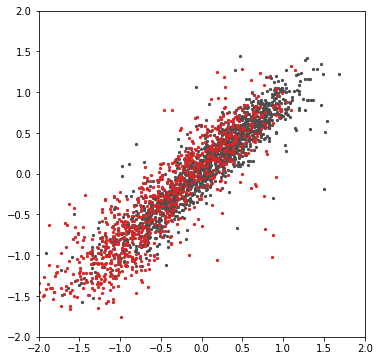

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(to_np(valid_trues.view(-1)), to_np(valid_preds.view(-1)), c='0.3', s=5)

plt.scatter(to_np(nibles_trues.view(-1)), to_np(nibles_preds.view(-1)), c='C3', s=5)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')

In [21]:
root_mean_squared_error(nibles_preds, nibles_trues), root_mean_squared_error(valid_preds, valid_trues)

(tensor(0.3657), tensor(0.2285))

# Train on $\alpha$.100

In [18]:
a100 = pd.read_csv(f'{PATH}/data/a.100_SDSS.csv')

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a100, path=PATH, bs=64)

In [10]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

In [11]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.383884,0.363273,00:57
1,0.302906,0.318668,00:51
2,0.317119,0.422355,00:51
3,0.327421,0.322537,00:51
4,0.313460,0.306598,00:52
5,0.302520,0.329095,00:51
6,0.292635,0.458406,00:51
7,0.301195,0.377512,00:51
8,0.294611,0.310283,00:51
9,0.295052,0.310504,00:52


## Get preds on all of a.100

In [27]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a100, path=PATH, bs=64, drop_last=False, shuffle_train=False)

In [28]:
a100_idx = dls.train.items.AGCNr
a100_preds, a100_trues = learn.get_preds(dl=dls.train, reorder=False)
a100_preds, a100_trues = to_np(a100_preds).flatten(), to_np(a100_trues).flatten()

a100_results = pd.DataFrame(
    {
        'fgas_pred': a100_preds,
        'fgas_true': a100_trues
    }, index=dls.train.items.AGCNr.astype(int)
)

In [29]:
a100 = a100.join(a100_results, on='AGCNr', rsuffix='_results', how='inner')

## Crossmatch with T17

following same as `nb 94`.

In [30]:
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)

try:
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)
except NameError:
    t17 = astropy.io.ascii.read(f'{PATH}/data/Teimoorinia+17.csv').to_pandas().loc[2:]

    t17 = t17.astype(
        {
            'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
            'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
            'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
        }
    )
    
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

In [31]:
cutoff = 1 / 3600
idx_t17, idx_a100, _, _ = a100_coords.search_around_sky(t17_coords, cutoff*u.deg)
len(list(idx_a100)), len(set(idx_a100)), len(list(idx_t17)), len(set(idx_t17))

(10326, 10326, 10326, 10326)

In [32]:
t17_x_a100 = t17.iloc[idx_t17]
a100_x_t17 = a100.iloc[idx_a100]

a100_x_t17.reset_index(drop=True, inplace=True)
t17_x_a100.reset_index(inplace=True)

t17_x_a100 = t17_x_a100.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)

a100_x_t17 = a100_x_t17.join(t17_x_a100, rsuffix='_T17')


In [33]:
# a100_x_t17.to_csv(f'{PATH}/results/predictions/a100xT17-v2_trained-on-a100.csv', index='AGCNr')
a100_x_t17 = pd.read_csv(f'{PATH}/results/predictions/a100xT17-v2_trained-on-a100.csv', index_col='AGCNr')

In [34]:
def summary_stats(preds, trues, mask):
    """Given preds, trues, and some PR conditional mask, 
    output the total number (N), RMSE, slope, std, and offset.
    """    
    return (
        sum(mask), 
        ((preds[mask] - trues[mask])**2).mean()**0.5, 
        slope(preds[mask], trues[mask]),
        (preds[mask] - trues[mask]).std(), 
        (preds[mask].mean() - trues[mask].mean()),
    )


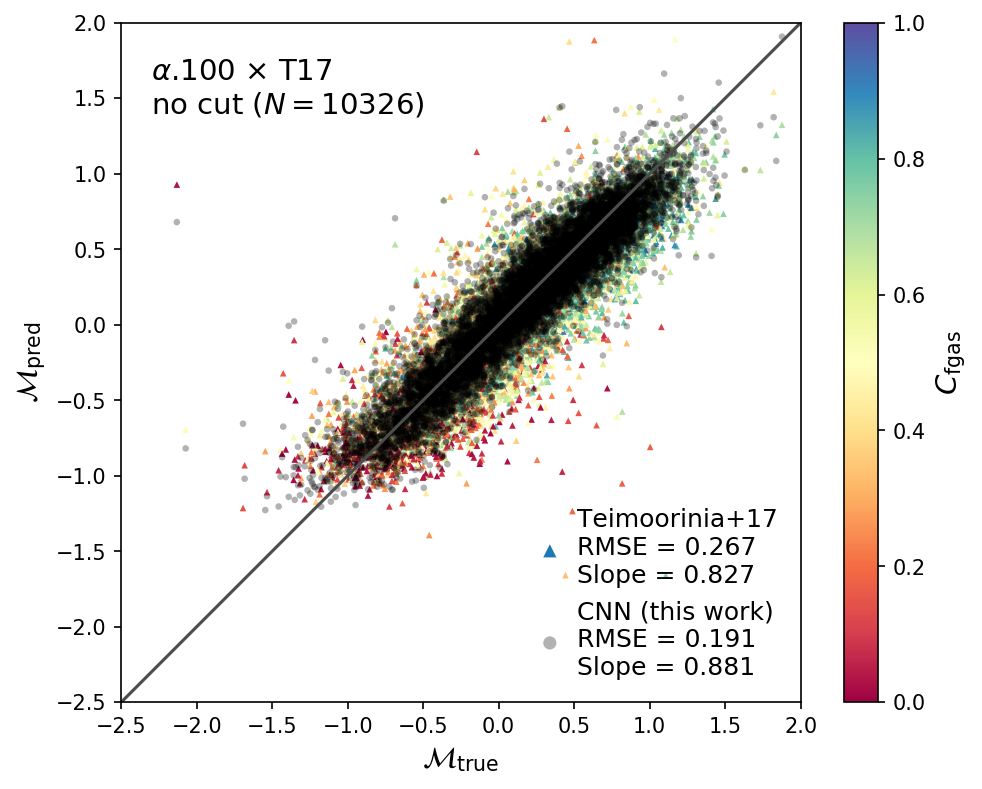

In [36]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = np.ones_like(a100_x_t17.Cfgas, dtype=bool)
N, rmse_a100_T17, slope_a100_T17, _, _ = summary_stats(a100_x_t17.fgas_t17, a100_x_t17.fgas_true, mask)
_, rmse_a100_CNN, slope_a100_CNN, _, _ = summary_stats(a100_x_t17.fgas_pred, a100_x_t17.fgas_true, mask)

sc = plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_t17, c=a100_x_t17[mask].Cfgas, edgecolors='none', cmap='Spectral', marker='^', s=10, vmin=0., vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_a100_T17:.3f}\nSlope = {slope_a100_T17:.3f}')
plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=10, label=f'CNN (this work)\nRMSE = {rmse_a100_CNN:.3f}\nSlope = {slope_a100_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'$\alpha$.100 $\times$ T17' '\n' r'no cut' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

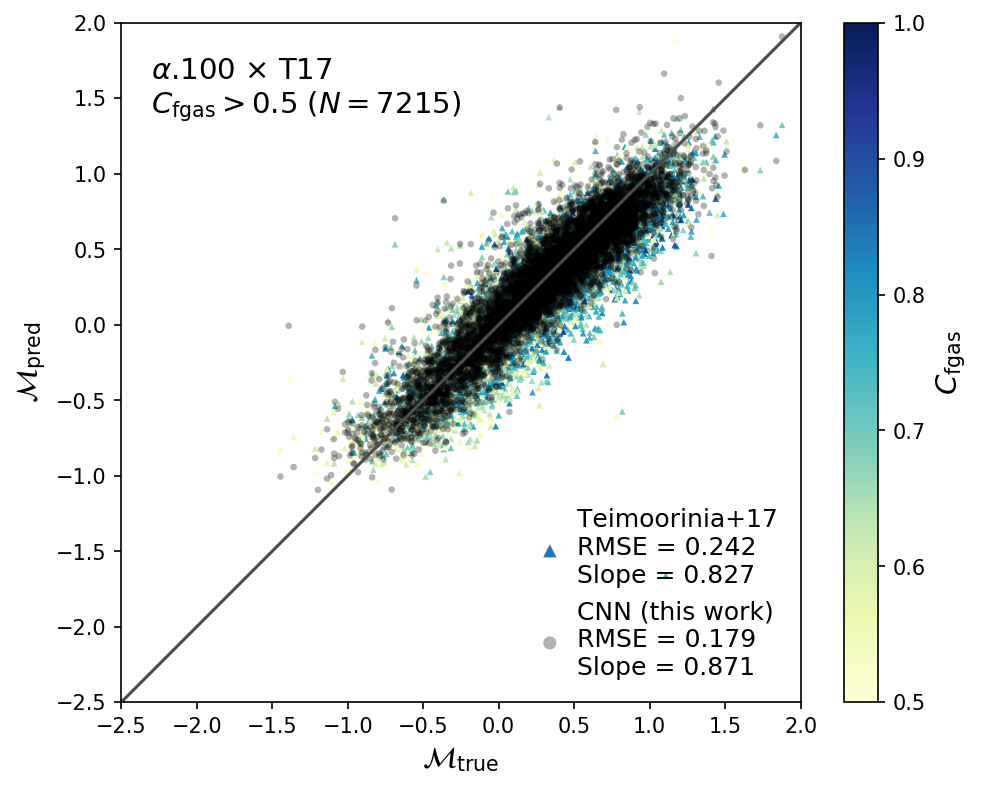

In [35]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = a100_x_t17.Cfgas > 0.5
N, rmse_a100_T17, slope_a100_T17, _, _ = summary_stats(a100_x_t17.fgas_t17, a100_x_t17.fgas_true, mask)
_, rmse_a100_CNN, slope_a100_CNN, _, _ = summary_stats(a100_x_t17.fgas_pred, a100_x_t17.fgas_true, mask)

sc = plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_t17, c=a100_x_t17[mask].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=10, vmin=0.5, vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_a100_T17:.3f}\nSlope = {slope_a100_T17:.3f}')
plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=10, label=f'CNN (this work)\nRMSE = {rmse_a100_CNN:.3f}\nSlope = {slope_a100_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'$\alpha$.100 $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

# Clean up 100% catalog

## Remove nearby optical counterparts

In [38]:
# remove nearby optical counterparts
sdss = pd.read_csv(f"{PATH}/data/SDSS_basic_data.csv")
sdss_coords = SkyCoord(sdss[['ra', 'dec']].values * u.deg)

In [39]:
ind, sep2d, _ = matching.match_coordinates_sky(
    a100_coords,
    sdss_coords,
    nthneighbor=2,
)

In [40]:
sum(sep2d < 55*u.arcsec)

555

In [41]:
a100 = a100[sep2d > 55*u.arcsec]

## Remove nearby HI counterparts

In [47]:
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)

In [46]:
ind, sep2d, _ = matching.match_coordinates_sky(
    a100_coords,
    a100_coords,
    nthneighbor=2,
)

In [48]:
sum(sep2d < 1.9*u.arcmin)

127

In [49]:
a100 = a100[sep2d > 1.9*u.arcmin]

In [ ]:
ind, sep2d, _ = matching.match_coordinates_sky(
    a100_coords,
    sdss_coords,
    nthneighbor=1,
)

## Check SDSS crossmatch is robust -- yes, all 11432 sources are crossmatched.

In [56]:
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)
len(a100_coords)

11432

In [53]:
cutoff = 1 / 3600
idx_sdss, idx_a100, _, _ = a100_coords.search_around_sky(sdss_coords, cutoff*u.deg)


In [54]:
sdss_x_a100 = sdss.iloc[idx_sdss]
a100_x_sdss = a100.iloc[idx_a100]

a100_x_sdss.reset_index(drop=True, inplace=True)
sdss_x_a100.reset_index(inplace=True)

a100_x_sdss = a100_x_sdss.join(sdss_x_a100, rsuffix='_sdss')


In [55]:
len(a100_x_sdss)

11432

In [60]:
np.allclose(a100_x_sdss.z, a100_x_sdss.z_sdss)

True

In [61]:
# since all of them are already crossmatched
# a100_x_sdss.to_csv(f'{PATH}/data/a100_cleaned_sdss.csv', index='AGCNr')
a100_x_sdss = pd.read_csv(f'{PATH}/data/a100_cleaned_sdss.csv', index_col='AGCNr')


## Retrain with cleaner sample

In [ ]:
a100_x_sdss = pd.read_csv(f'{PATH}/data/a100_cleaned_sdss.csv', index_col='AGCNr')

In [62]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a100_x_sdss, path=PATH, bs=64)

In [63]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.400857,0.387747,00:48
1,0.338525,0.305968,00:48
2,0.314868,0.267183,00:48
3,0.305681,0.316012,00:48
4,0.295007,0.655483,00:48
5,0.320122,0.260855,00:48
6,0.303405,0.285577,00:48
7,0.306470,0.315778,00:48
8,0.291601,0.282618,00:48
9,0.300421,0.325496,00:48


In [70]:
# learn.save('fastai2-xresnet34-a100_clean-1')
learn = learn.load('fastai2-xresnet34-a100_clean-1');

In [73]:
a100_x_sdss = pd.read_csv(f'{PATH}/data/a100_cleaned_sdss.csv')

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a100_x_sdss, path=PATH, bs=64, drop_last=False, shuffle_train=False)

In [74]:
a100_idx = dls.train.items.AGCNr
a100_preds, a100_trues = learn.get_preds(dl=dls.train, reorder=False)
a100_preds, a100_trues = to_np(a100_preds).flatten(), to_np(a100_trues).flatten()

a100_results = pd.DataFrame(
    {
        'fgas_pred': a100_preds,
        'fgas_true': a100_trues
    }, index=dls.train.items.AGCNr.astype(int)
)

In [76]:
a100 = a100_x_sdss.join(a100_results, on='AGCNr', rsuffix='_results', how='inner')

In [77]:
a100.shape

(11432, 64)

## Crossmatch with T17

In [81]:
a100_coords = SkyCoord(a100.RAdeg_OC, a100.DECdeg_OC, unit=u.deg)

try:
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)
except NameError:
    t17 = astropy.io.ascii.read(f'{PATH}/data/Teimoorinia+17.csv').to_pandas().loc[2:]

    t17 = t17.astype(
        {
            'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
            'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
            'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
        }
    )
    
    t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

In [82]:
cutoff = 1 / 3600
idx_t17, idx_a100, _, _ = a100_coords.search_around_sky(t17_coords, cutoff*u.deg)
len(list(idx_a100)), len(set(idx_a100)), len(list(idx_t17)), len(set(idx_t17))

(9763, 9763, 9763, 9763)

In [83]:
t17_x_a100 = t17.iloc[idx_t17]
a100_x_t17 = a100.iloc[idx_a100]

a100_x_t17.reset_index(drop=True, inplace=True)
t17_x_a100.reset_index(inplace=True)

t17_x_a100 = t17_x_a100.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)

a100_x_t17 = a100_x_t17.join(t17_x_a100, rsuffix='_T17')


In [84]:
# a100_x_t17.to_csv(f'{PATH}/results/predictions/a100xT17-v2_trained-on-a100_clean.csv', index='AGCNr')
a100_x_t17 = pd.read_csv(f'{PATH}/results/predictions/a100xT17-v2_trained-on-a100_clean.csv', index_col='AGCNr')

In [ ]:
print('      N,   RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a100_x_t17.fgas_pred, a100_x_t17.fgas_true, np.ones_like(a100_x_t17.Cfgas, dtype=bool))))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a100_x_t17.fgas_t17, a100_x_t17.fgas_true, np.ones_like(a100_x_t17.Cfgas, dtype=bool))))))
)



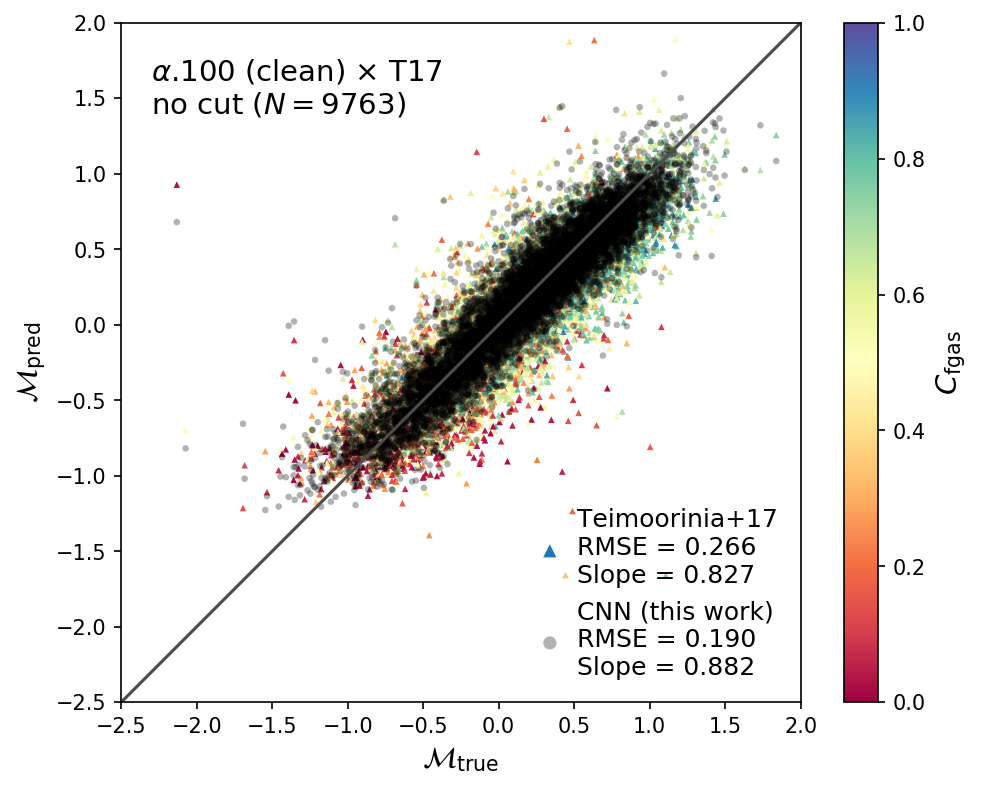

In [88]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = np.ones_like(a100_x_t17.Cfgas, dtype=bool)
N, rmse_a100_T17, slope_a100_T17, _, _ = summary_stats(a100_x_t17.fgas_t17, a100_x_t17.fgas_true, mask)
_, rmse_a100_CNN, slope_a100_CNN, _, _ = summary_stats(a100_x_t17.fgas_pred, a100_x_t17.fgas_true, mask)

sc = plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_t17, c=a100_x_t17[mask].Cfgas, edgecolors='none', cmap='Spectral', marker='^', s=10, vmin=0., vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_a100_T17:.3f}\nSlope = {slope_a100_T17:.3f}')
plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=10, label=f'CNN (this work)\nRMSE = {rmse_a100_CNN:.3f}\nSlope = {slope_a100_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'$\alpha$.100 (clean) $\times$ T17' '\n' r'no cut' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

In [91]:
print('      N,   RMSE, slope,  std, offset')

print(
    'CNN:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a100_x_t17.fgas_pred, a100_x_t17.fgas_true, a100_x_t17.Cfgas > 0.5)))))
)

print(
    'T17:  ' + ' '.join(list(map(str, map(
        partial(np.round, decimals=4), 
        summary_stats(a100_x_t17.fgas_t17, a100_x_t17.fgas_true, a100_x_t17.Cfgas > 0.5)))))
)



      N,   RMSE, slope,  std, offset
CNN:  6839 0.1781 0.8707 0.1775 -0.0147
T17:  6839 0.242 0.8268 0.2284 -0.0799


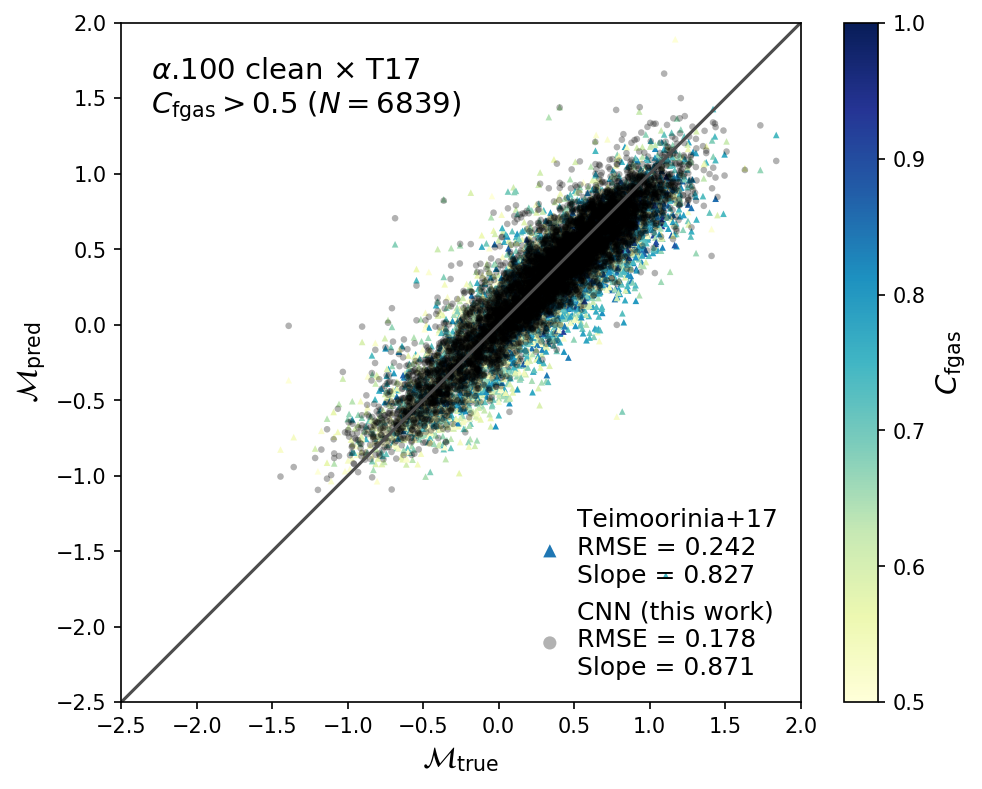

In [89]:
plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
mask = a100_x_t17.Cfgas > 0.5
N, rmse_a100_T17, slope_a100_T17, _, _ = summary_stats(a100_x_t17.fgas_t17, a100_x_t17.fgas_true, mask)
_, rmse_a100_CNN, slope_a100_CNN, _, _ = summary_stats(a100_x_t17.fgas_pred, a100_x_t17.fgas_true, mask)

sc = plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_t17, c=a100_x_t17[mask].Cfgas, edgecolors='none', cmap='YlGnBu', marker='^', s=10, vmin=0.5, vmax=1, label=f'Teimoorinia+17\nRMSE = {rmse_a100_T17:.3f}\nSlope = {slope_a100_T17:.3f}')
plt.scatter(a100_x_t17[mask].fgas_true, a100_x_t17[mask].fgas_pred, c='k', edgecolors='none', alpha=0.3, s=10, label=f'CNN (this work)\nRMSE = {rmse_a100_CNN:.3f}\nSlope = {slope_a100_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'$\alpha$.100 clean $\times$ T17' '\n' r'$C_{\rm fgas} > 0.5$' f' ($N={N}$)', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=2, handletextpad=0.1)

# Retrain with a.100 "final" sample

In [6]:
a100 = pd.read_csv(f'{PATH}/data/final/a100.csv')

In [9]:

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a100, path=PATH, bs=64, drop_last=False, shuffle_train=False)

In [10]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)

learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,0.402505,0.345917,00:48
1,0.330397,0.388319,00:48
2,0.318667,0.292147,00:48
3,0.307008,0.309027,00:48
4,0.310399,0.373258,00:48
5,0.311950,0.266839,00:48
6,0.301376,0.362909,00:48
7,0.297005,0.503984,00:48
8,0.294289,0.355468,00:48
9,0.287719,0.350438,00:48


In [11]:
# learn.save('fastai2-xresnet34-a100_final-1')

# Train xGASS

In [5]:
xg = pd.read_csv(f'{PATH}/data/final/xGASS.csv')

xg_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['lgGF'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [6]:
xg_dls = ImageDataLoaders.from_dblock(xg_dblock, xg, path=PATH, bs=64)
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(xg_dls, model, loss_func=root_mean_squared_error, opt_func=ranger)


## Train from scratch

In [7]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,time
0,1.258576,1.234486,00:06
1,1.094078,1.020893,00:05
2,0.894260,0.620741,00:06
3,0.742430,0.695809,00:05
4,0.644338,0.608773,00:05
5,0.568776,0.496513,00:05
6,0.520583,1.221196,00:05
7,0.494480,0.501566,00:05
8,0.476556,0.403241,00:05
9,0.462054,0.439179,00:05


## Try transfer learning

In [9]:
learn = learn.load('fastai2-xresnet34-a40A-1');

In [10]:
learn.fit_one_cycle(40, slice(1e-3,))

epoch,train_loss,valid_loss,time
0,1.170043,1.008040,00:05
1,1.161353,1.088551,00:05
2,1.146615,1.075619,00:05
3,1.118085,0.978634,00:06
4,1.065870,0.854382,00:05
5,0.968838,0.500285,00:05
6,0.810972,0.337965,00:06
7,0.680151,0.316253,00:05
8,0.586024,0.314811,00:06
9,0.518055,0.368671,00:05


In [11]:
a40B_preds, a40B_trues = learn.get_preds()


In [14]:
root_mean_squared_error(a40B_preds, a40B_trues)

tensor(0.3058)

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

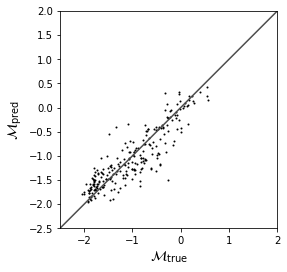

In [15]:
plt.scatter(a40B_trues, a40B_preds, c='k', s=1)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


In [ ]:
res = a40B
label = r'$\alpha$.40A $\times$ T17'

plt.figure(figsize=(7.5, 6), dpi=150)

# get stats
PR_accept = res.p_CNN > p
N, rmse_T17, slope_T17, _, _ = summary_stats(res.fgas_t17, res.fgas_true, PR_accept)
_, rmse_CNN, slope_CNN, _, _ = summary_stats(res.fgas_pred, res.fgas_true, PR_accept)

plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_t17, c='k', edgecolors='none', alpha=0.3, marker='^', s=5, label=f'Teimoorinia+17\nRMSE = {rmse_T17:.3f}\nSlope = {slope_T17:.3f}')
sc = plt.scatter(res[PR_accept].fgas_true, res[PR_accept].fgas_pred, edgecolors='none', c=res[PR_accept].p_CNN, cmap='YlGnBu', s=5, vmin=p, vmax=1, label=f'CNN (this work)\nRMSE = {rmse_CNN:.3f}\nSlope = {slope_CNN:.3f}')
cbar = plt.colorbar(sc)
cbar.set_label(r'CNN PR', fontsize=14)

plt.plot([-2.5, 2], [-2.5, 2], c='0.3')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, label + r' ($p_{\rm CNN}>$' f'{p:.1f})' + '\n' + f'$N$ = {N}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, framealpha=0, markerscale=3, handletextpad=0.1)